In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# ResNet50 による 1000種類分類
import torchvision.models as models

from PIL import Image
import torchvision.transforms as transforms
import glob
from sklearn.svm import LinearSVC
import time

In [17]:
torch.cuda.device_count()

2

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
start = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
end = time.time()
print("time:", end-start)

[1,  2000] loss: 2.183
[1,  4000] loss: 1.821
[1,  6000] loss: 1.620
[1,  8000] loss: 1.538
[1, 10000] loss: 1.489
[1, 12000] loss: 1.450
[2,  2000] loss: 1.379
[2,  4000] loss: 1.360
[2,  6000] loss: 1.330
[2,  8000] loss: 1.318
[2, 10000] loss: 1.287
[2, 12000] loss: 1.271
Finished Training
time: 91.08191514015198


### 2 devices

In [19]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = nn.DataParallel(Net())
net = net.to(device)

cuda:0


In [20]:
start = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
end = time.time()
print("time:", end-start)

[1,  2000] loss: 2.307
[1,  4000] loss: 2.306
[1,  6000] loss: 2.306
[1,  8000] loss: 2.305
[1, 10000] loss: 2.303
[1, 12000] loss: 2.306
[2,  2000] loss: 2.305
[2,  4000] loss: 2.306
[2,  6000] loss: 2.305
[2,  8000] loss: 2.306
[2, 10000] loss: 2.304
[2, 12000] loss: 2.306
Finished Training
time: 229.42594861984253


## 遅くなってしまった。<br>
原因としてバッチサイズの大きさがあると思われる<br>
https://aru47.hatenablog.com/entry/2020/11/06/225052 <br>
よってバッチサイズ4->256とした。

In [37]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [38]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

In [39]:
start = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
end = time.time()
print("time:", end-start)

Finished Training
time: 10.522781133651733


### 2 devices

In [40]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = nn.DataParallel(Net())
net = net.to(device)

cuda:0


In [41]:
start = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
end = time.time()
print("time:", end-start)

Finished Training
time: 10.477876663208008


結果的に初期に比べてかなり速くなったので、十秒程度に収束 <br>
差が少なくなってボトルネックが発生しているように思う。

### EX.VGG16

In [51]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [52]:
vgg16 = models.vgg16(pretrained=True,progress=True)
softmax=nn.Softmax(dim=1)

In [53]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.size(0), -1)

In [54]:
# vgg16 のconvの学習済パラメータはfinetuneしないように凍結します．
for param in vgg16.features.parameters():
    param.requires_grad = False

# finetune用の model の定義．最後のlayerをcutして，nn.Linear(4096,10) を追加
model = torch.nn.Sequential(
    vgg16.features,
    vgg16.avgpool,
    Flatten(),
    *list(vgg16.classifier.children())[:-1],  # 最後のlayer(fc1000)を削除
    nn.Linear(4096,10)
)
# 表示してみます．10class分のfc出力が最終出力になっているはずです．
print(model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [55]:
# GPUに転送します．
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
# callback のクラス ShowGraphを定義
class ShowGraph:
    def __init__(self,max_epoch):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0.5, 1.0])
        self.fig1.set_title('accuracy')
        self.fig1.set_ylabel('accuracy')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([0, max_epoch, 0, 5])
        self.fig2.set_title('loss')
        self.fig2.set_ylabel('loss')
        self.fig2.set_xlabel('epoch')
        self.max_epoch=max_epoch
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.losses_val=[]
        self.acc=[]
        self.acc_val=[]
        self.n_epoch=[]
        self.n_epoch_v=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, loss, acc, vloss, vacc):
        self.n_epoch.append(epoch)
        self.n_epoch_v.append(epoch)
        self.acc.append(acc)
        self.acc_val.append(vacc)     
        self.losses.append(loss)
        self.losses_val.append(vloss)    
        self.test_acc=vacc
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
        self.fig1.plot(self.n_epoch_v,self.acc_val,"r")
        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
        self.fig2.plot(self.n_epoch_v,self.losses_val,"r")
        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
        
    def on_epoch_train(self, epoch, loss, acc): # validationを評価しないepochの表示用
        self.n_epoch.append(epoch)
        self.acc.append(acc)
        self.losses.append(loss)
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
#        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
#        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
              
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val acc値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("val_acc: ",self.test_acc) 
        print('Time: ',time.time()-self.start)

val_acc:  0.6635
Time:  236.06972002983093


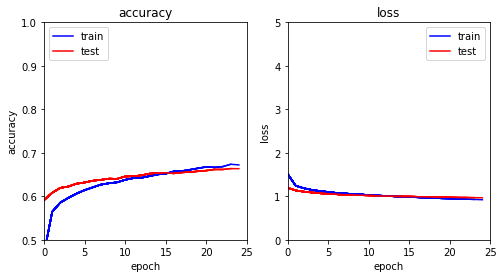

In [57]:
num_epoch=25
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=0.00001)
#optimizer = optim.Adam(model.parameters())
show_graph=ShowGraph(num_epoch)
show_graph.on_train_begin();
def train():
    loss=0
    total=0
    total0=0
    correct=0
    model.train()
    for i, (inputs, labels) in enumerate(trainloader, 0):
        outputs = model(inputs.to(device))
        labels=labels.to(device)
        loss0= loss_fn(outputs, labels)
        loss+= loss0.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        total0+=1
        correct += (predicted == labels).sum().item()
        optimizer.zero_grad()
        loss0.backward()
        optimizer.step()
    loss=loss/total0
    acc=correct/total 
    return loss, acc

def validate():
    model.eval()
    with torch.no_grad():
         vloss=0
         total2=0
         total20=0
         correct2=0
         for (inputs, labels) in testloader:
             outputs = model(inputs.to(device))
             labels=labels.to(device)
             vloss += loss_fn(outputs, labels).item()
             _, predicted = torch.max(outputs.data, 1)
             total2 += labels.size(0)
             total20+=1
             correct2 += (predicted == labels).sum().item()
         vloss=vloss/total20
         vacc=correct2/total2
    return vloss, vacc   

for epoch in range(num_epoch):
    l, a = train()   
    lv, av = validate()
    scheduler.step(lv) # val_lossが下がらなければlrを下げる
    show_graph.on_epoch_end(epoch,l,a,lv,av)
            
del show_graph

### 2 devices

In [58]:
# finetune用の model の定義．最後のlayerをcutして，nn.Linear(4096,10) を追加
model = torch.nn.Sequential(
    vgg16.features,
    vgg16.avgpool,
    Flatten(),
    *list(vgg16.classifier.children())[:-1],  # 最後のlayer(fc1000)を削除
    nn.Linear(4096,10)
)

In [59]:
# GPUに転送します．
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = nn.DataParallel(model)
model = model.to(device)

val_acc:  0.676
Time:  781.5684423446655


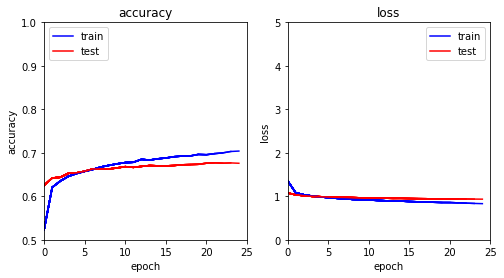

In [60]:
num_epoch=25
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=0.00001)
#optimizer = optim.Adam(model.parameters())
show_graph=ShowGraph(num_epoch)
show_graph.on_train_begin();
def train():
    loss=0
    total=0
    total0=0
    correct=0
    model.train()
    for i, (inputs, labels) in enumerate(trainloader, 0):
        outputs = model(inputs.to(device))
        labels=labels.to(device)
        loss0= loss_fn(outputs, labels)
        loss+= loss0.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        total0+=1
        correct += (predicted == labels).sum().item()
        optimizer.zero_grad()
        loss0.backward()
        optimizer.step()
    loss=loss/total0
    acc=correct/total 
    return loss, acc

def validate():
    model.eval()
    with torch.no_grad():
         vloss=0
         total2=0
         total20=0
         correct2=0
         for (inputs, labels) in testloader:
             outputs = model(inputs.to(device))
             labels=labels.to(device)
             vloss += loss_fn(outputs, labels).item()
             _, predicted = torch.max(outputs.data, 1)
             total2 += labels.size(0)
             total20+=1
             correct2 += (predicted == labels).sum().item()
         vloss=vloss/total20
         vacc=correct2/total2
    return vloss, vacc   

for epoch in range(num_epoch):
    l, a = train()   
    lv, av = validate()
    scheduler.step(lv) # val_lossが下がらなければlrを下げる
    show_graph.on_epoch_end(epoch,l,a,lv,av)
            
del show_graph

認識率自体は少しよいが、過学習が見られるのと、並列計算の利点が少なくなっている。  
極端にバッチサイズを上げないとうまくいかないのかもしれない。

### 参考
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar <br>
https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html <br>
https://qiita.com/kamorits/items/6f342da395ad57468ae3 <br>
http://mm.cs.uec.ac.jp/sys/text19/kadai2-4pt.html<br>